# The Lattice Boltzmann Method - stress and force

This notebook uses the Lattice Boltzmann (LBM) Method for numerical simulation of fluid flow to calculate the flow around a sphere. Written in python and jax. This notebook will focus on the stress tensor and force acting on the sphere.
The stress tensor will be determined [using Chapman-Enskog expansions](https://arxiv.org/pdf/0812.3242.pdf), force will be determined using the Momentum Exchange Method to calculate the drag coefficient. In the end, only the drag coefficient will be presented, since it is non-dimensional.

The code is adjusted from the the code presented by Machine Learning & Simulation (MLS) in 2D:
- On [Youtube](https://www.youtube.com/watch?v=ZUXmO4hu-20&list=LL&index=1&ab_channel=MachineLearning%26Simulation) and [Github](https://github.com/Ceyron/machine-learning-and-simulation/blob/main/english/simulation_scripts/lattice_boltzmann_method_python_jax.py)

And expanded to 3D:
- In [Google Colab](https://colab.research.google.com/drive/1F3EH9_2N3lkEpgQXOScR3lcQ6oqCARPk?usp=sharing) and on [Github](https://github.com/Ceyron/machine-learning-and-simulation/blob/main/english/simulation_scripts/D3Q19_lattice_bolzmann_method_python_jax.py)

It is recommended to watch that video first and go through the notebook in 3D, because a lot of explanation of this method, the setup and syntax mentioned in that video and code will be skipped here.

In [1]:
# Install relevant packages supported by colab by default
!pip install cmasher

# Import packages
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import cmasher as cmr
from matplotlib import cm
from tqdm import tqdm

# Enable 64bit
jax.config.update("jax_enable_x64", True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.3/533.3 kB 5.5 MB/s eta 0:00:00


# Setup of the domain
First we will setup the general parameters of the domain. Not the notation **_L** next to some of the parameters. It is to stress the use of lattice units. We will simulate a sphere in a laminar flow. This can look a little boring withouth the Karman Vortex shedding that occurs with cylinders in this regime, but determining the drag on a 3D object like this is at least to me just as exiting!

We are using the BGK-method so the code will be simpler and easier to follow along with previous examples. A lot of the code will look familiar.


Reynolds number:   100
Mach number:       0.06
Relaxation time:   0.506


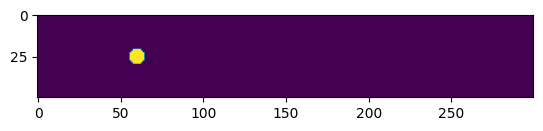

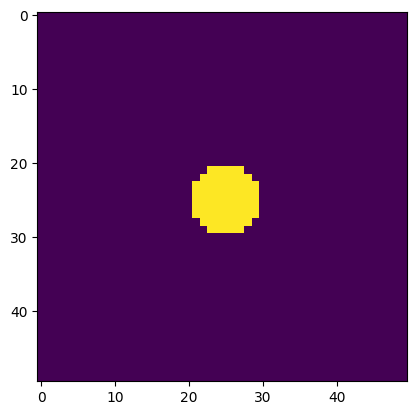

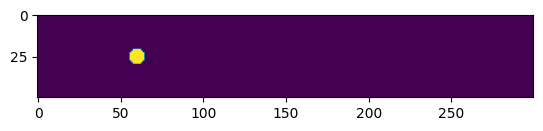

In [2]:
# Dimensions of domain in number of grid cells
ny = 50
nz = 50
nx = 300
radius_L = 5

# Setup the flow regime
KINEMATIC_VISCOSITY_L        = 0.002
HORIZONTAL_INFLOW_VELOCITY_L = 0.02

# Setup simulation iterations and frequency of plots
NUMBER_OF_ITERATIONS = 5000
PLOT_EVERY_N_STEP = 250
SKIP_FIRST_N = 250

# Determin relevant coefficients and the relaxation time (or inversely, relaxation omega)
reynolds_number_L = (HORIZONTAL_INFLOW_VELOCITY_L * 2 * radius_L) / KINEMATIC_VISCOSITY_L
speed_of_sound_L = 1/jnp.sqrt(3)
mach_number_L = HORIZONTAL_INFLOW_VELOCITY_L / speed_of_sound_L**2
RELAXATION_OMEGA = (1.0 / (KINEMATIC_VISCOSITY_L/(speed_of_sound_L**2) + 0.5))

print(f'Reynolds number:  {reynolds_number_L: g}')
print(f'Mach number:      {mach_number_L: g}')
print(f'Relaxation time:  {1.0 /RELAXATION_OMEGA: g}')

# Define a mesh
x = jnp.arange(nx)
y = jnp.arange(ny)
z = jnp.arange(nz)
X, Y, Z = jnp.meshgrid(x, y, z, indexing="ij")

# Construct the sphere
sphere = jnp.sqrt((X - x[nx//5])**2 + (Y - y[ny//2])**2 + (Z - z[nz//2])**2)
OBSTACLE_MASK = sphere < radius_L

plt.imshow(OBSTACLE_MASK[:, :, nz//2].T)
plt.show()
plt.imshow(OBSTACLE_MASK[nx//5, :, :].T)
plt.show()
plt.imshow(OBSTACLE_MASK[:, ny//2, :].T)
plt.show()

In [3]:
# Setup the discrete velocities
N_DISCRETE_VELOCITIES = 19

LATTICE_INDICES =     jnp.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15,16,17,18])
LATICE_VELOCITIES_X = jnp.array([0, 1,-1, 0, 0, 0, 0, 1,-1, 1,-1, 1,-1, 1,-1, 0, 0, 0, 0])
LATICE_VELOCITIES_Y = jnp.array([0, 0, 0, 1,-1, 0, 0, 1, 1,-1,-1, 0, 0, 0, 0, 1,-1, 1,-1])
LATICE_VELOCITIES_Z = jnp.array([0, 0, 0, 0, 0, 1,-1, 0, 0, 0, 0, 1, 1,-1,-1, 1, 1,-1,-1])

LATTICE_VELOCITIES = jnp.array([LATICE_VELOCITIES_X,
                                LATICE_VELOCITIES_Y,
                                LATICE_VELOCITIES_Z])

LATTICE_WEIGHTS = jnp.array([# rest particle
                             1/3,

                             # face-connected neighbors
                             1/18, 1/18, 1/18, 1/18, 1/18, 1/18,

                             # edge-connected neighbors
                             1/36, 1/36, 1/36, 1/36, 1/36, 1/36, 1/36, 1/36, 1/36, 1/36, 1/36, 1/36])

OPPOSITE_LATTICE_INDICES = jnp.array(
    [jnp.where(
        (LATTICE_VELOCITIES.T == -LATTICE_VELOCITIES[:, i])
        .all(axis = 1))[0]
     for i in range(N_DISCRETE_VELOCITIES)]).T[0]

RIGHT_VELOCITIES = jnp.where(LATICE_VELOCITIES_X == 1)[0]   # [ 1,  7,  9, 11, 13]
LEFT_VELOCITIES =  jnp.where(LATICE_VELOCITIES_X ==-1)[0]   # [ 2,  8, 10, 12, 14]
YZ_VELOCITIES =    jnp.where(LATICE_VELOCITIES_X == 0)[0]   # [ 0,  3,  4,  5,  6, 15, 16, 17, 18]

So far, everything should be looking familiar. We have setup the discrete velocities and determined which velocities are important for our boundary condition, streaming and collision steps. Now to dive into the method we are going to use to determine the stress, force and drag coefficient.

## Stress tensor

The stress tensor is the complete representation of the stresses on a point inside the fluid. The representation is most easily visualized on a grid cell:

![image](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b3/Components_stress_tensor_cartesian.svg/370px-Components_stress_tensor_cartesian.svg.png)

Where on each grid face the three arrows represents the forces along that grid face along the different axes. For each point in our grid the stress tensor $\sigma$ is:

\begin{equation*}
\sigma =
\begin{bmatrix}
\sigma_{xx} & \sigma_{xy} & \sigma_{xz} \\
\sigma_{yx} & \sigma_{yy} & \sigma_{yz} \\
\sigma_{zx} & \sigma_{zy} & \sigma_{zz}
\end{bmatrix}
\end{equation*}

$\sigma$ will therefor have a shape (nx, ny, nz, 3, 3) in 3D. On the row of the tensor are the faces of the above grid cell and on the columns the vector of the stress acting on that face. The unit of each value in the tensor is $\frac{N}{m^2}$ or $\frac{kg}{ms^2}$.

The stress tensor is closely related to the strain rate tensor $S$ (by $2 \nu S = \sigma$, where $\nu$ is the kinematic viscosity). $S$ is defined by the macroscopic velocities: $S=\frac{1}{2}\left[\frac{\delta u_\alpha}{\delta \beta} + \frac{\delta u_\beta}{\delta \alpha} \right]$ and can be solved using a finite differences scheme:

In [4]:
def get_strain_rate_tensor_FD(macroscopic_velocities):
  _gradients = jnp.gradient(
      macroscopic_velocities,
      axis = (0, 1, 2))
  gradients = jnp.einsum('d...D-> ...dD',
                         jnp.array(_gradients))
  return - (gradients +
            jnp.einsum('...ij -> ...ji',
                       gradients)
            )/2

 The advantage of using LBM for determining the stress tensor, is that it can be determined locally (i.e. no need to look at the neighbouring nodes) by ([source](https://arxiv.org/pdf/0812.3242.pdf)):

$σ_{\alpha \beta} = (1-\frac{1}{2\tau}) *  \displaystyle\sum_{i}c_{i \alpha}c_{i \beta} f^{neq}_{i}$

where $f^{neq}$ is the non-equilibrium discrete velocities defined by:
$f^{neq} = f - f^{eq}$, the deviation of the pre-colission discrete velocities from their equilibrium values. $c_{i \alpha}$ are the lattice velocities over the axis of the rows of the stress tensor and $c_{i \beta}$the lattice velocities over the axis of the column of the stress tensor.

Below, the formula has been reduced to the necessary functions, and one converting the stress tensor into the rate of strain tensor to compare it with the finite differences solution.

In [5]:
alpha, beta = jnp.meshgrid(jnp.arange(3), jnp.arange(3))
CACB = (LATTICE_VELOCITIES[alpha, :] *
        LATTICE_VELOCITIES[beta,  :])

def get_stress_tensor(discrete_velocities, macroscopic_velocities, density):
  equilibrium_discrete_velocities = get_equilibrium_discrete_velocities(
                                      macroscopic_velocities,
                                      density)
  non_equilibrium_discrete_velocities = (discrete_velocities -
                                         equilibrium_discrete_velocities)

  stress_tensor = ((1 - RELAXATION_OMEGA / 2) *
                   jnp.sum(CACB[jnp.newaxis, jnp.newaxis, jnp.newaxis, ...] *
                           non_equilibrium_discrete_velocities[:, :, :, jnp.newaxis, jnp.newaxis, :],
                           axis = -1))
  return stress_tensor

def get_strain_rate_tensor_LB(discrete_velocities, macroscopic_velocities, density):
  stress_tensor = get_stress_tensor(discrete_velocities, macroscopic_velocities, density)
  strain_rate_tensor = (stress_tensor /
                        (2 *
                         density[..., jnp.newaxis, jnp.newaxis] *
                         KINEMATIC_VISCOSITY_L)
                        )
  return strain_rate_tensor

## Force

Here we determine the forces acting on the object using the momentum exchange method. Momentum is the mass of an object times its velocity. Force and momentum are related by a change in time, as in: force is momentum over time. The momentum in Lattice Boltzmann space is $f_i c_i$, which are the lattice velocities of each lattice index multiplied by their discrete counterpart. When we see the populations $f_i$ of our lattices as particles, we can determine the momentum of those particles hitting the object and transfering their momentum. To determine this exchange of momentum, we need to determine which populations would cross the object boundary (both from the fluid into the object and the other way around).


The method here moves the mask of the fluid with the lattice volicities and checks of the fluid encounters the object (and vice versa).

In [6]:
MOMENTUM_EXCHANGE_MASK_IN  = jnp.zeros((nx, ny, nz, 19)) > 0
MOMENTUM_EXCHANGE_MASK_OUT = jnp.zeros((nx, ny, nz, 19)) > 0

for i, (x, y, z) in enumerate(LATTICE_VELOCITIES.T):
  # Determine the momentum going into the object:
  location_in = jnp.logical_and(
              jnp.roll(
                  jnp.logical_not(OBSTACLE_MASK),
                  (x, y, z),
                  axis = (0, 1, 2)),
              OBSTACLE_MASK)

  MOMENTUM_EXCHANGE_MASK_IN = MOMENTUM_EXCHANGE_MASK_IN.at[location_in, i].set(True)

  # Determine the momentum going out of the object:
  location_out = jnp.logical_and(
              jnp.roll(
                  OBSTACLE_MASK,
                  (-x, -y, -z),
                  axis = (0, 1, 2)),
              jnp.logical_not(OBSTACLE_MASK))

  MOMENTUM_EXCHANGE_MASK_OUT = MOMENTUM_EXCHANGE_MASK_OUT.at[location_out, OPPOSITE_LATTICE_INDICES[i]].set(True)

Now that we know which populations of particles are going to move across the object boudary, we can assess the total momentum exchange ($\Delta P$ by summing the momentum of the populations crossing the boundary:

$\Delta P_L =  \displaystyle\sum_i(f_i c_i - f_{\hat{i}} c_{\hat{i}})$

Where $i$ indicates the poplution moving into the object and $\hat{i}$ the population out of the object. Since $c_{\hat{i}} = -c_i$ above formula can be rewritten as:

$\Delta P_L =  \displaystyle\sum_i c_i(f_i + f_{\hat{i}})$

Momentum and force are related by $F_L = \Delta P_L/\Delta t_L$. Since lattice time is 1 per step we can directly get the force:

In [7]:
@jax.jit
def get_force(discrete_velocities):
  return jnp.sum(
                 (LATTICE_VELOCITIES.T[jnp.newaxis, jnp.newaxis, jnp.newaxis, ...] *
                  discrete_velocities[..., jnp.newaxis])[MOMENTUM_EXCHANGE_MASK_IN] +
                 (LATTICE_VELOCITIES.T[OPPOSITE_LATTICE_INDICES][jnp.newaxis, jnp.newaxis, jnp.newaxis, ...] *
                  discrete_velocities[..., jnp.newaxis])[MOMENTUM_EXCHANGE_MASK_OUT],
                 axis = 0
                 )

The below functions are applied to the 3D simulation of the BGK-LBM as discussed in the previous notebook:

In [8]:
def get_density(discrete_velocities):
    density = jnp.sum(discrete_velocities, axis=-1)
    return density

def get_macroscopic_velocities(discrete_velocities, density):
    return jnp.einsum("...Q,dQ->...d", discrete_velocities, LATTICE_VELOCITIES) / density[..., jnp.newaxis]

def get_equilibrium_discrete_velocities(macroscopic_velocities, density):
    projected_discrete_velocities = jnp.einsum("dQ,...d->...Q", LATTICE_VELOCITIES, macroscopic_velocities)
    macroscopic_velocity_magnitude = jnp.linalg.norm(macroscopic_velocities, axis=-1, ord=2)
    equilibrium_discrete_velocities = (density[..., jnp.newaxis] * LATTICE_WEIGHTS[jnp.newaxis, jnp.newaxis, jnp.newaxis, :] *
        (1 + 3 * projected_discrete_velocities + 9/2 * projected_discrete_velocities**2 -
        3/2 * macroscopic_velocity_magnitude[..., jnp.newaxis]**2))
    return equilibrium_discrete_velocities

VELOCITY_PROFILE = jnp.zeros((nx, ny, nz, 3))
VELOCITY_PROFILE = VELOCITY_PROFILE.at[:, :, :, 0].set(HORIZONTAL_INFLOW_VELOCITY_L)
discrete_velocities_prev = get_equilibrium_discrete_velocities(VELOCITY_PROFILE,
                                                               jnp.ones((nx, ny, nz)))

In [9]:
@jax.jit
def update(discrete_velocities_prev):
    # (1) Prescribe the outflow BC on the right boundary. Flow can go out, but not back in.
    discrete_velocities_prev = discrete_velocities_prev.at[-1, ..., LEFT_VELOCITIES].set(discrete_velocities_prev[-2, ..., LEFT_VELOCITIES])

    # (2) Determine macroscopic velocities
    density_prev = get_density(discrete_velocities_prev)
    macroscopic_velocities_prev = get_macroscopic_velocities(
        discrete_velocities_prev,
        density_prev)

    # (3) Prescribe Inflow Dirichlet BC using Zou/He scheme in 3D:
    macroscopic_velocities_prev = macroscopic_velocities_prev.at[0, ..., :].set(VELOCITY_PROFILE[0, ..., :])
    lateral_densities = get_density(jnp.einsum('i...->...i', discrete_velocities_prev[0, ..., YZ_VELOCITIES]))
    left_densities = get_density(jnp.einsum('i...->...i', discrete_velocities_prev[0, ..., LEFT_VELOCITIES]))
    density_prev = density_prev.at[0, ...].set((lateral_densities + 2 * left_densities) /
                                                (1 - macroscopic_velocities_prev[0, ..., 0]))

    # (4) Compute discrete Equilibria velocities
    equilibrium_discrete_velocities = get_equilibrium_discrete_velocities(
       macroscopic_velocities_prev,
       density_prev)

    # (3) Belongs to the Zou/He scheme
    discrete_velocities_prev =\
          discrete_velocities_prev.at[0, ..., RIGHT_VELOCITIES].set(
              equilibrium_discrete_velocities[0, ..., RIGHT_VELOCITIES])

    # (5) Collide according to BGK
    discrete_velocities_post_collision = (discrete_velocities_prev - RELAXATION_OMEGA *
          (discrete_velocities_prev - equilibrium_discrete_velocities))

    # (6) Bounce-Back Boundary Conditions to enfore the no-slip
    for i in range(N_DISCRETE_VELOCITIES):
        discrete_velocities_post_collision = discrete_velocities_post_collision.at[OBSTACLE_MASK, LATTICE_INDICES[i]].set(
                                                      discrete_velocities_prev[OBSTACLE_MASK, OPPOSITE_LATTICE_INDICES[i]])

    # (7) Stream alongside lattice velocities
    discrete_velocities_streamed = discrete_velocities_post_collision
    for i in range(N_DISCRETE_VELOCITIES):
        discrete_velocities_streamed = discrete_velocities_streamed.at[..., i].set(
            jnp.roll(discrete_velocities_post_collision[..., i],
            LATTICE_VELOCITIES[:, i], axis = (0, 1, 2)))

    return discrete_velocities_streamed


## Applying the code
When exucting the code, the velocity magnitude for each PLOT_EVERY_N is displayed, together with a comparison of the finite differences solution for the strain rate tensor and the LB strain rate tensor. In addition the drag coefficient over time is shown, from the time after SKIP_FIRS_N to get the initial clutter out of the way.

The stress tensor is difficult to display, because of its 9 entries per cell. Below the shear stress $\sigma_{xy}$ (over axis 0 and 1) is shown, showing the stress applied on the x-plain over its y-axis. Red indicates a positive shear stress over the y-axis (shearing upward) and blue a negative shear stress. The stress tensor is not needed in running the LBM, but it gives a nice view of the stress in the model and since the final result can be chaotic, earlier representations can more clearly show what is going on stress-wise.

  5%|▌         | 250/5000 [00:10<01:43, 45.96it/s]

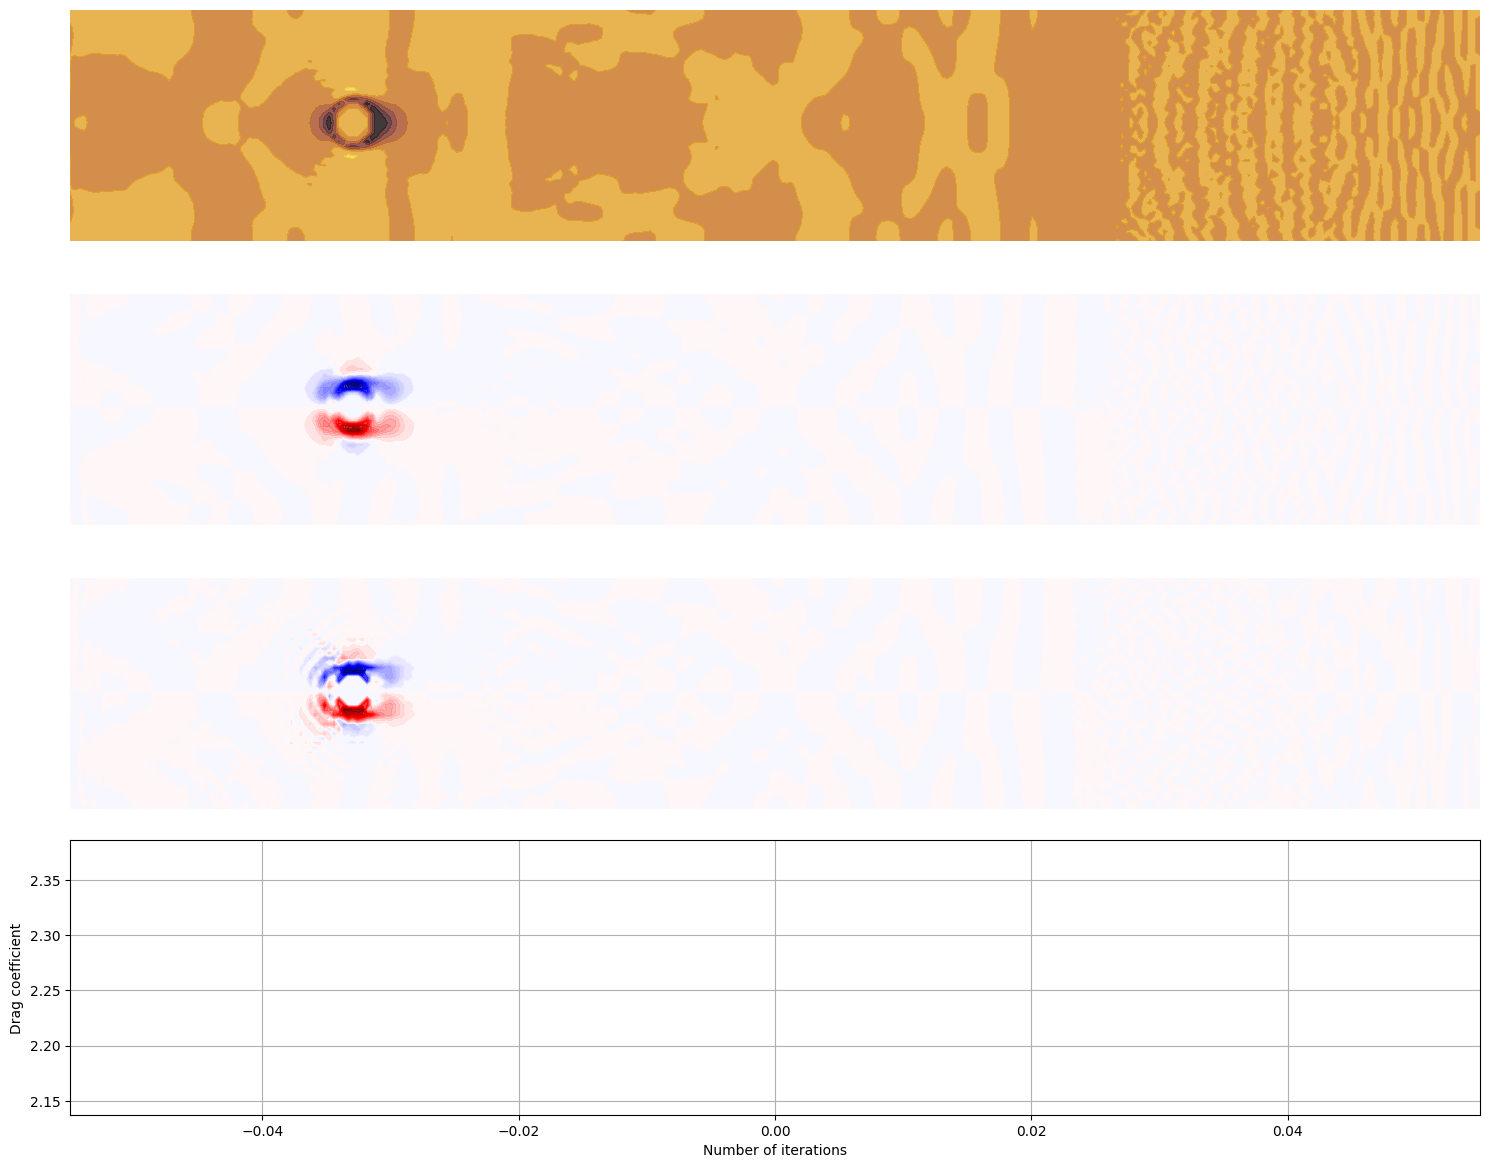

 10%|▉         | 497/5000 [00:19<01:38, 45.60it/s]

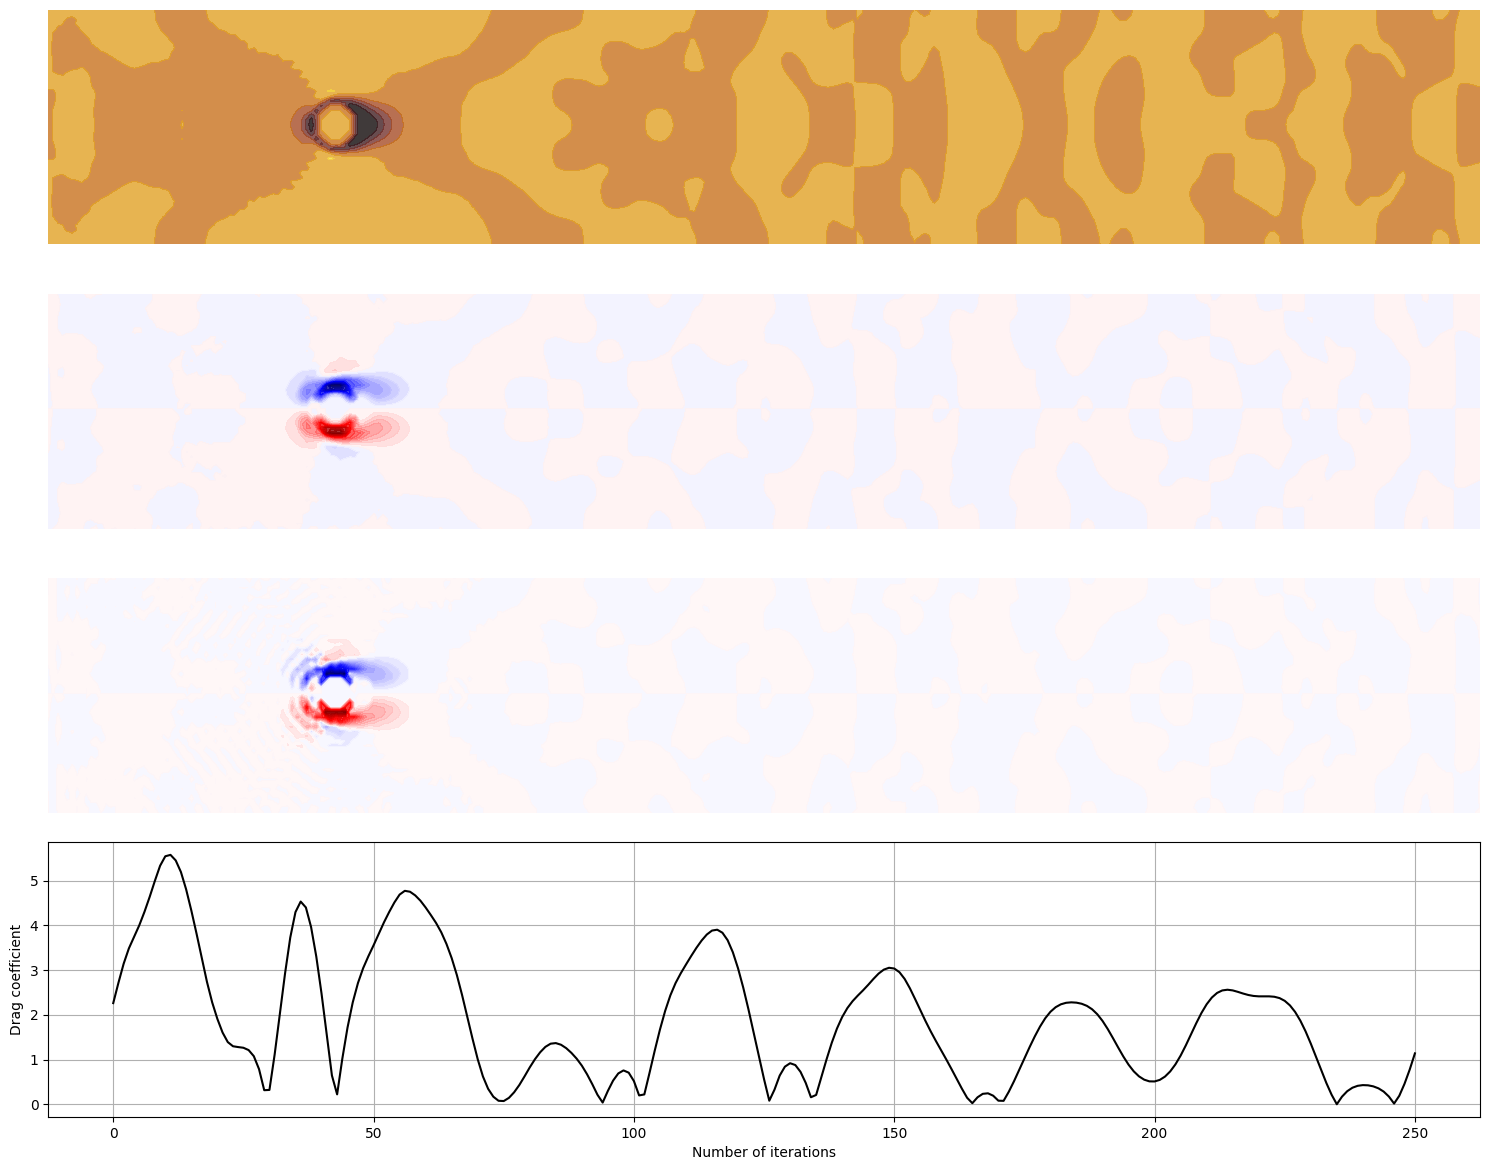

 15%|█▌        | 750/5000 [00:25<01:33, 45.28it/s]

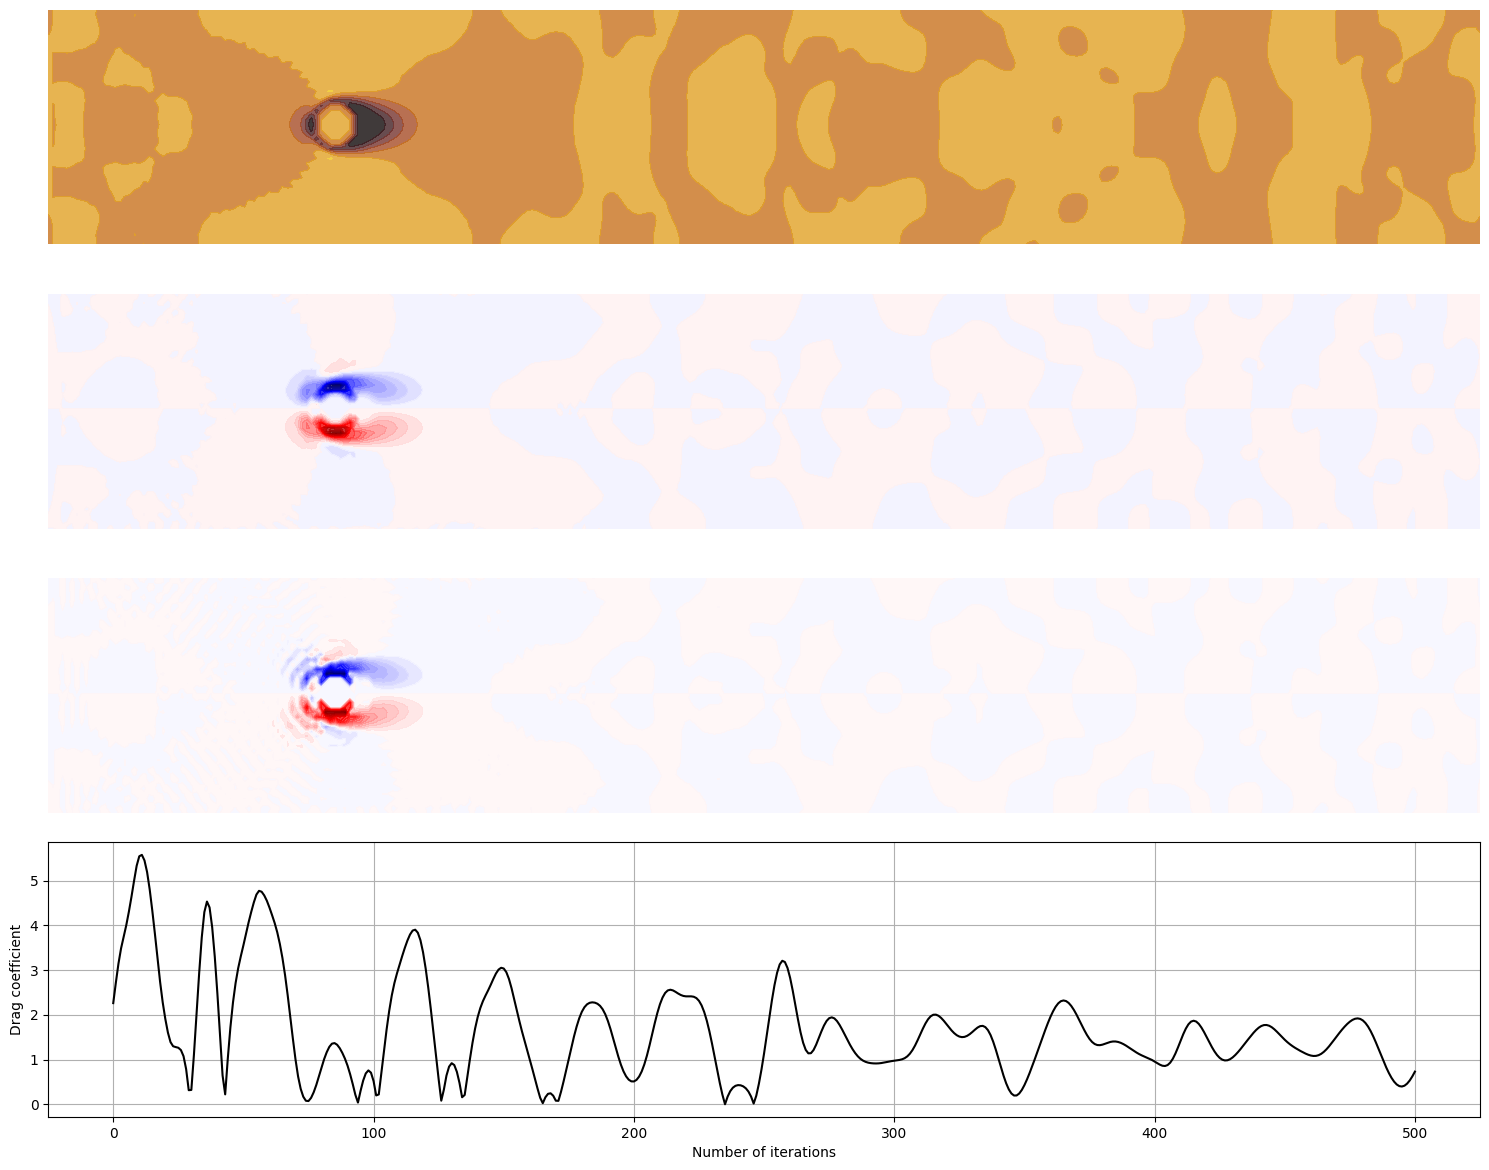

 20%|██        | 1000/5000 [00:31<01:28, 44.96it/s]

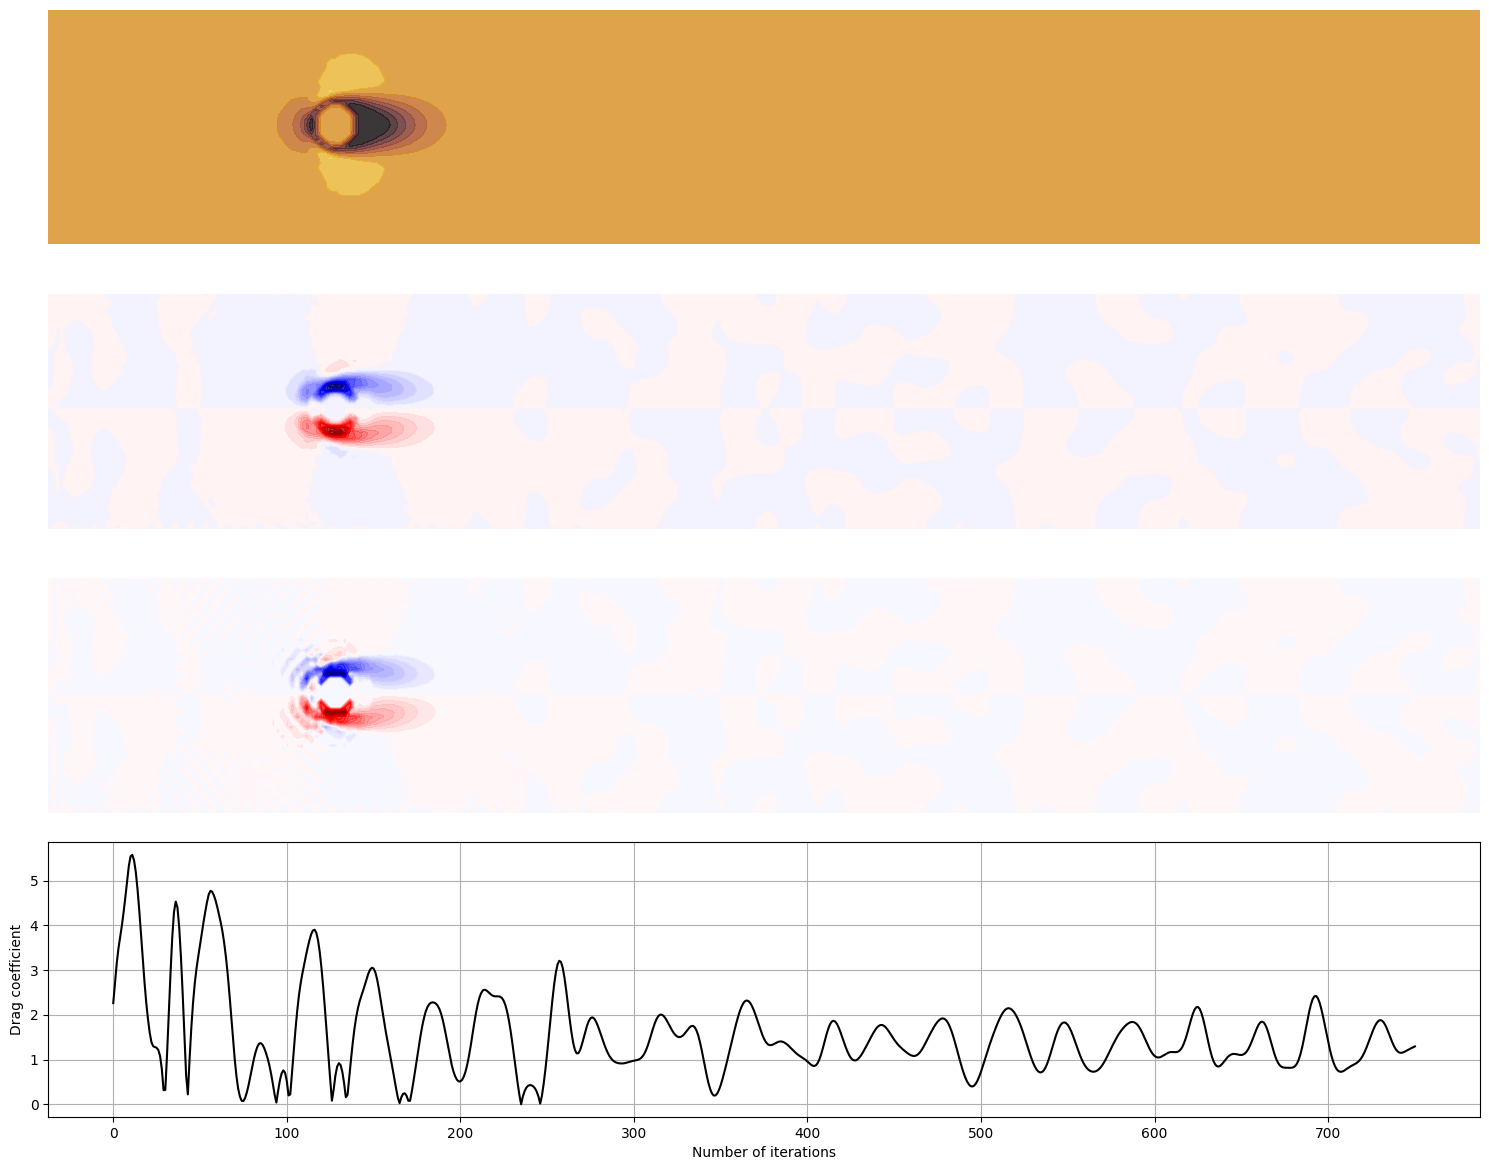

 25%|██▌       | 1250/5000 [00:37<01:23, 44.99it/s]

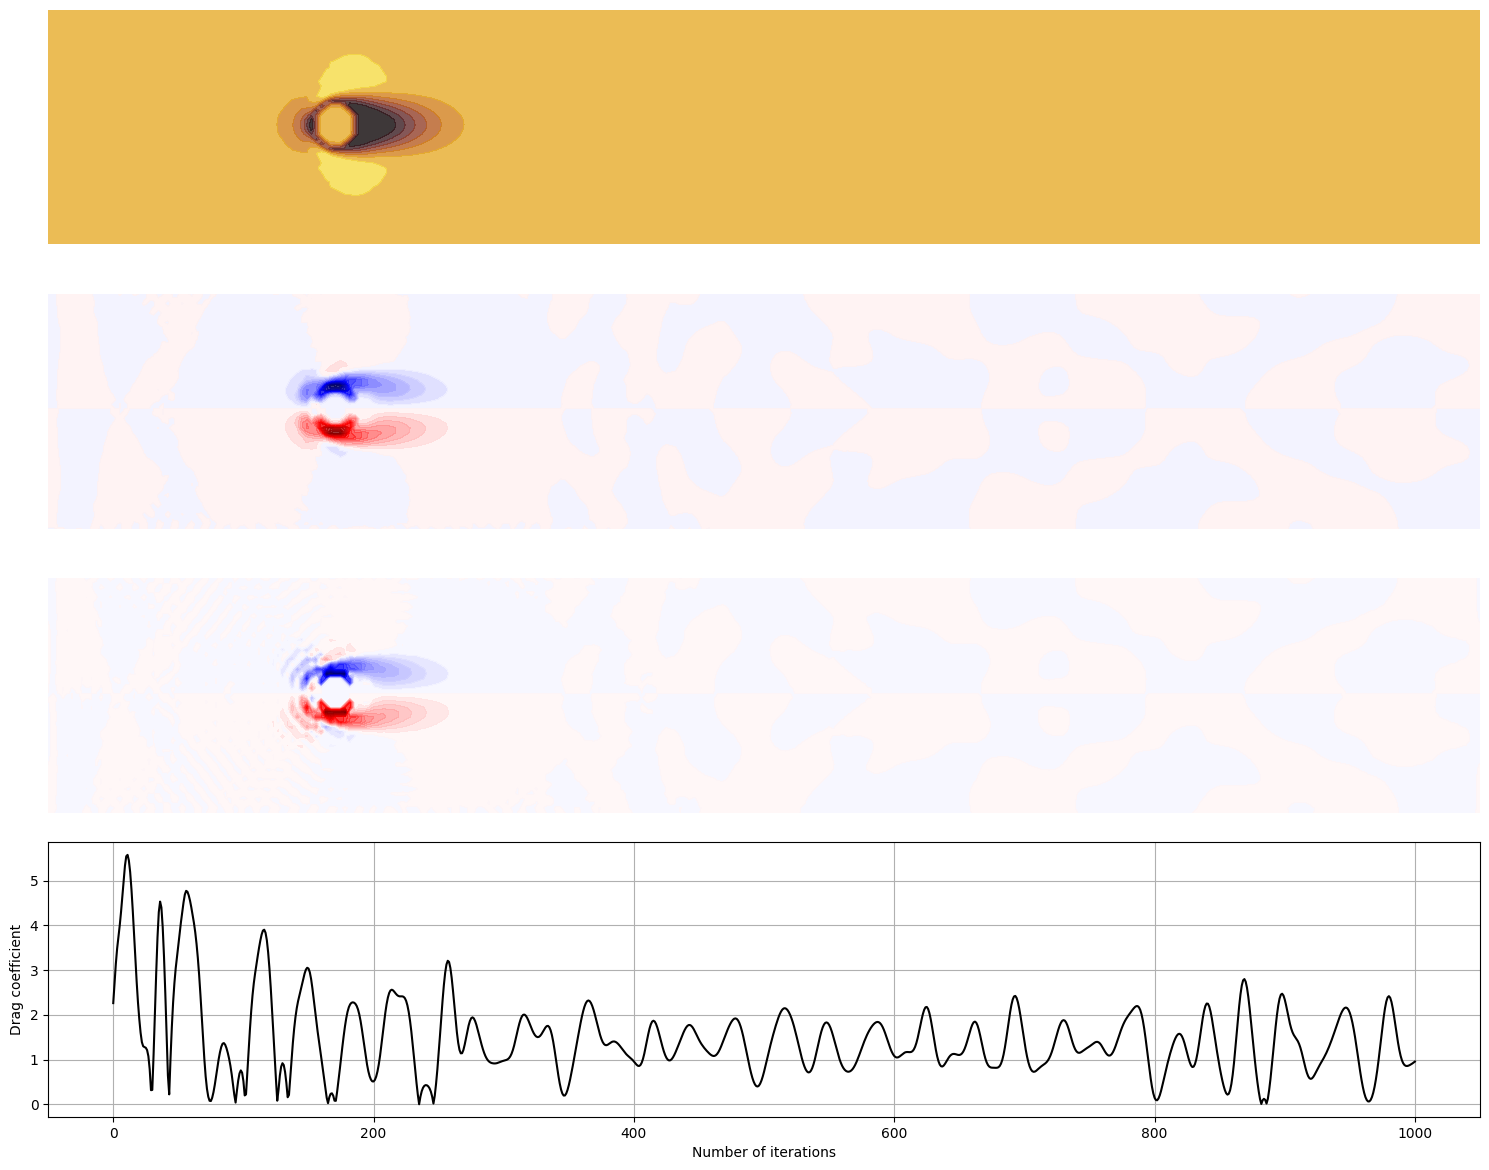

 30%|███       | 1500/5000 [00:43<01:17, 45.09it/s]

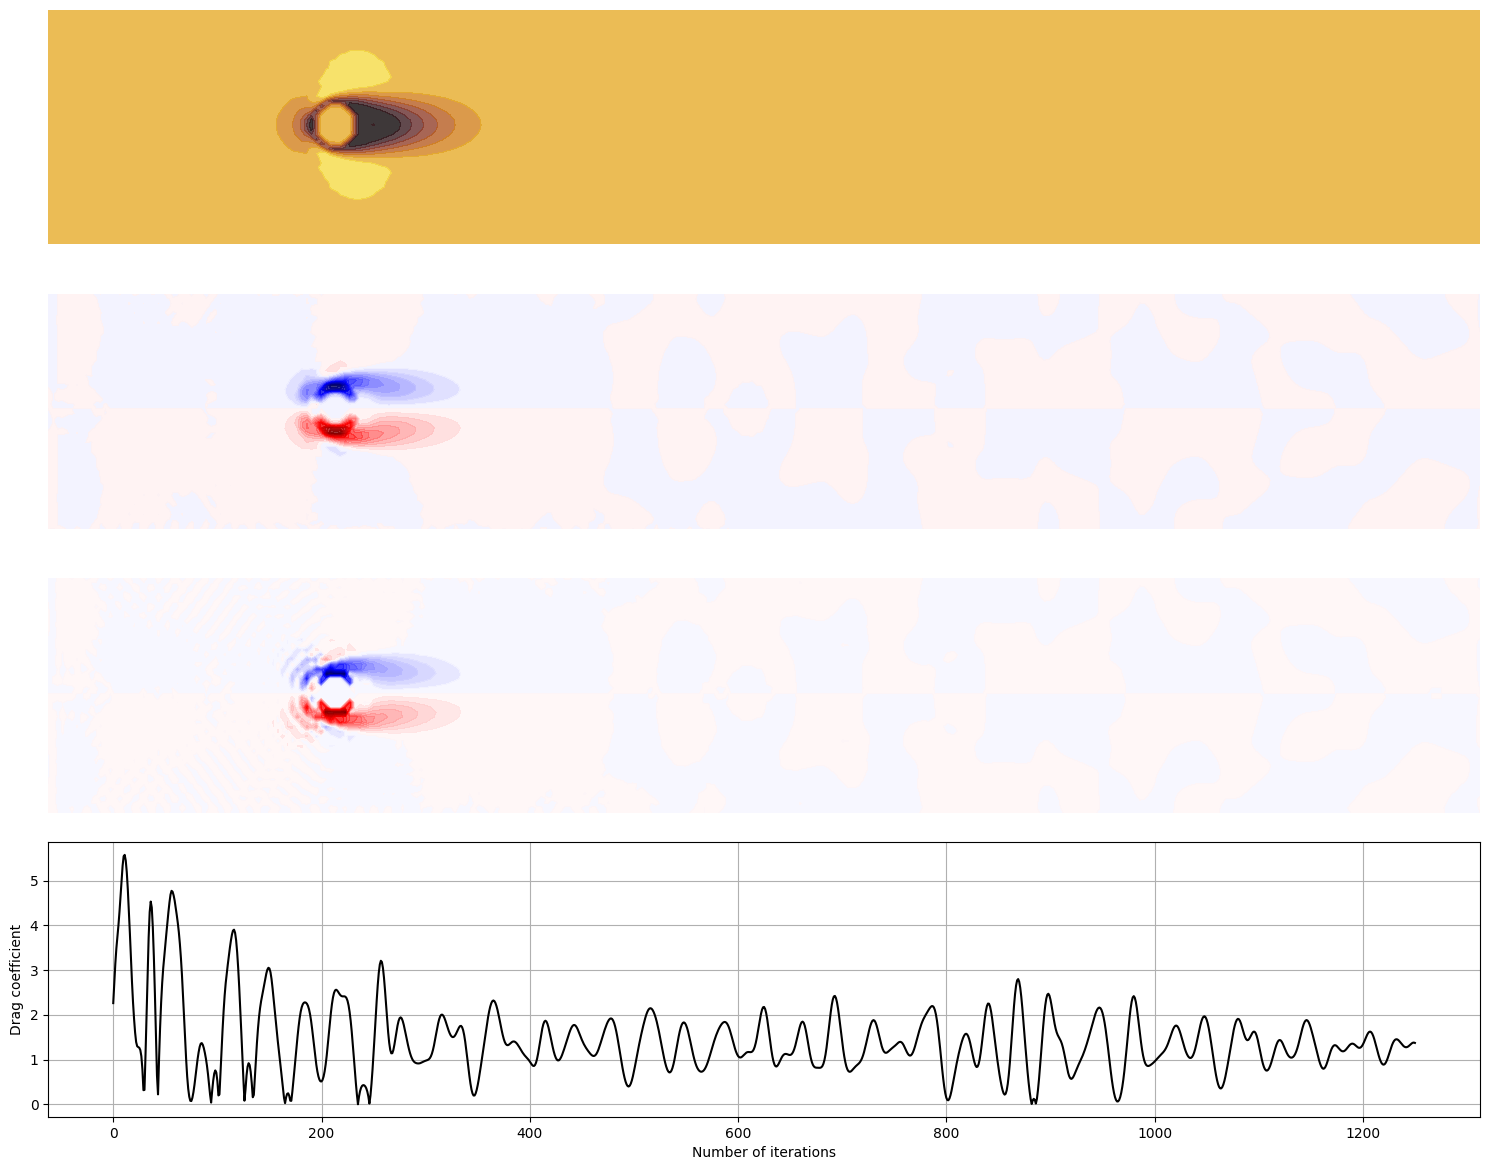

 35%|███▌      | 1750/5000 [00:49<01:11, 45.16it/s]

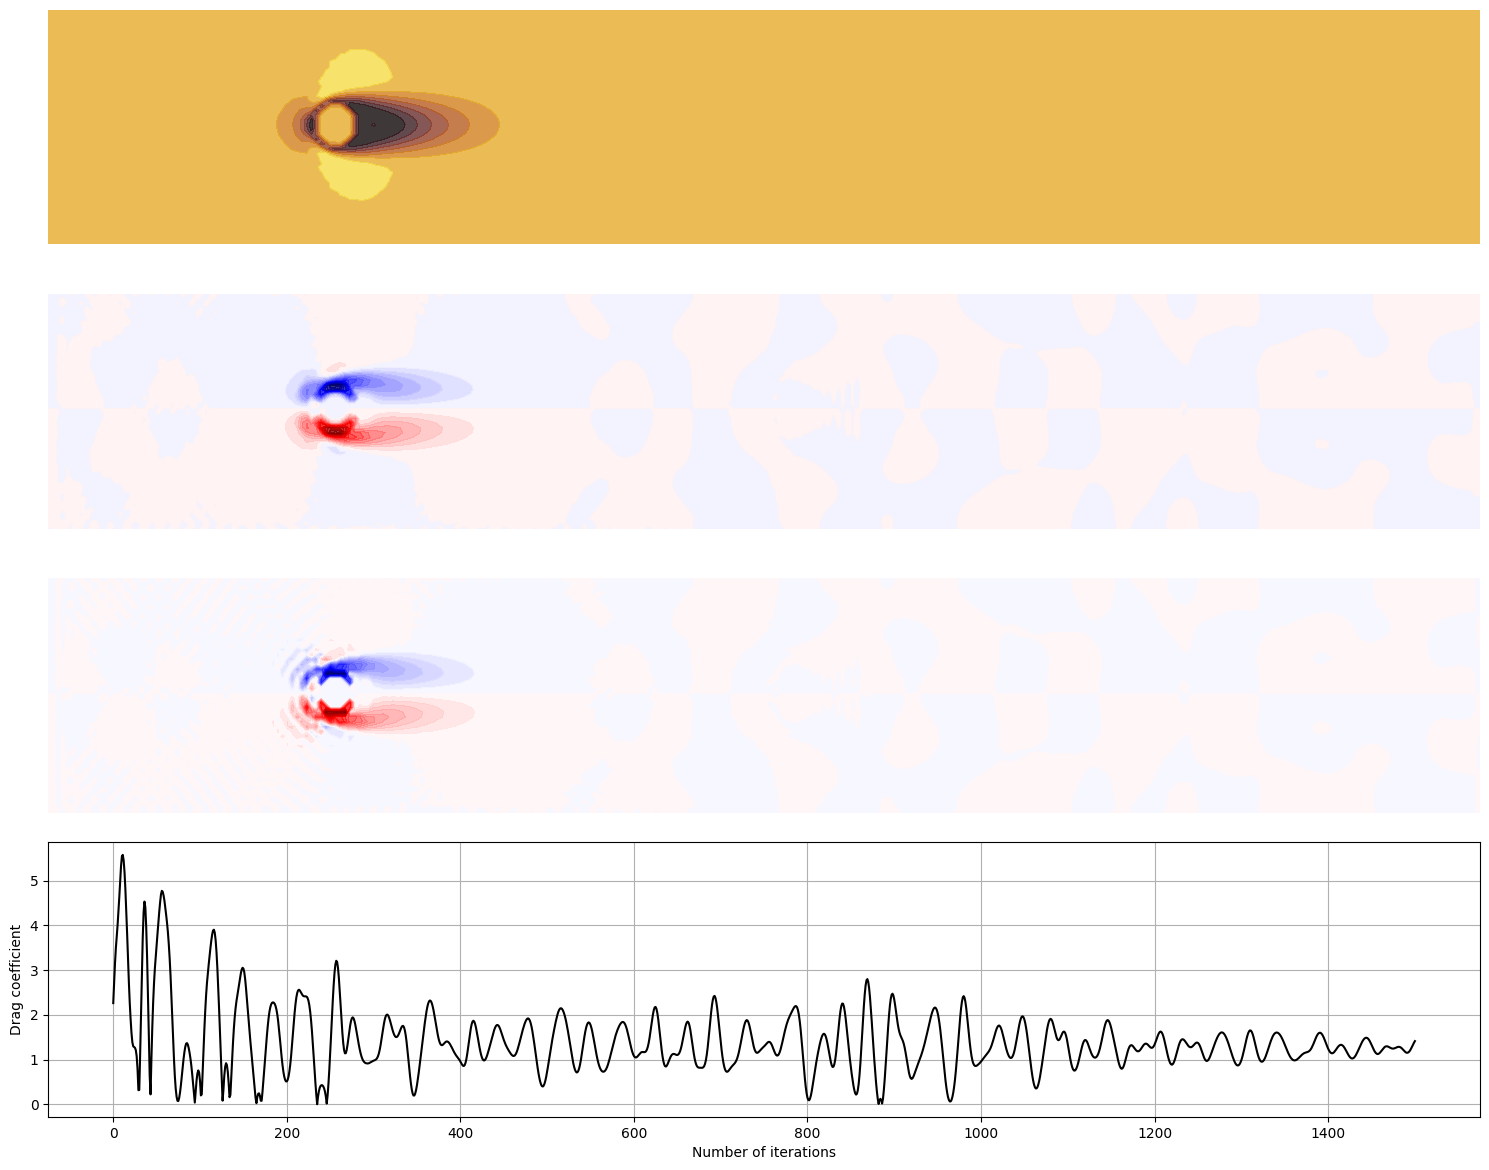

 40%|████      | 2000/5000 [00:56<01:05, 45.63it/s]

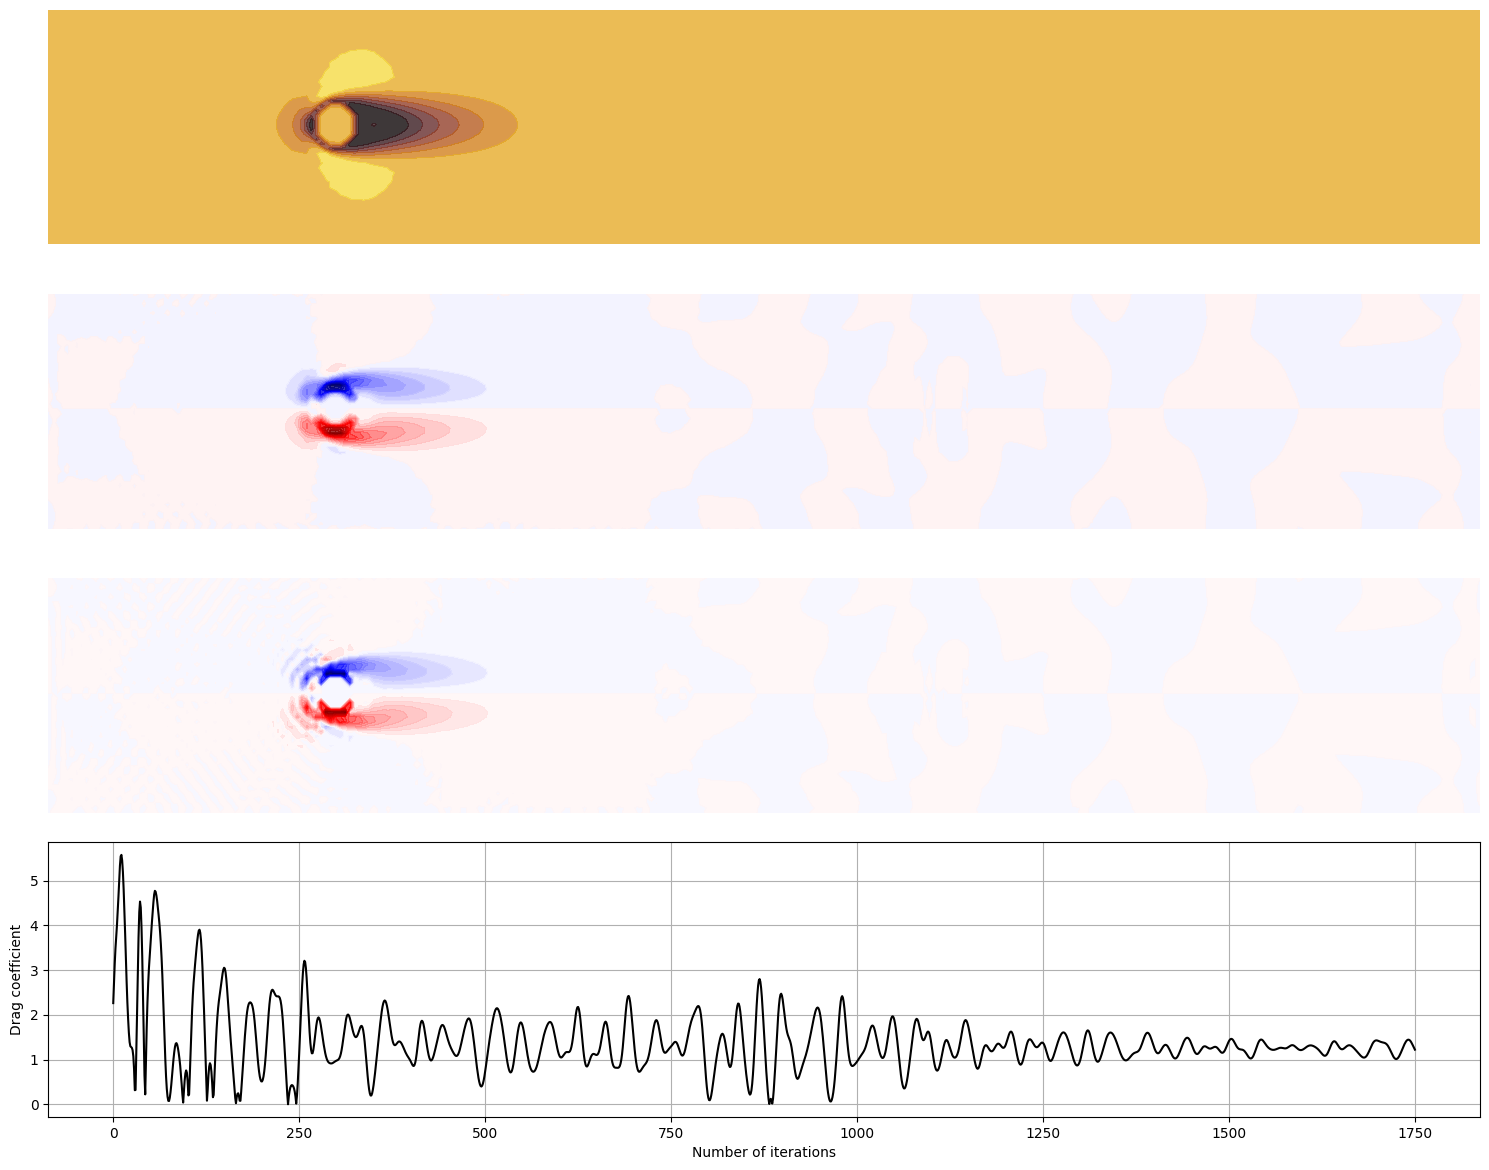

 45%|████▌     | 2250/5000 [01:02<00:59, 45.86it/s]

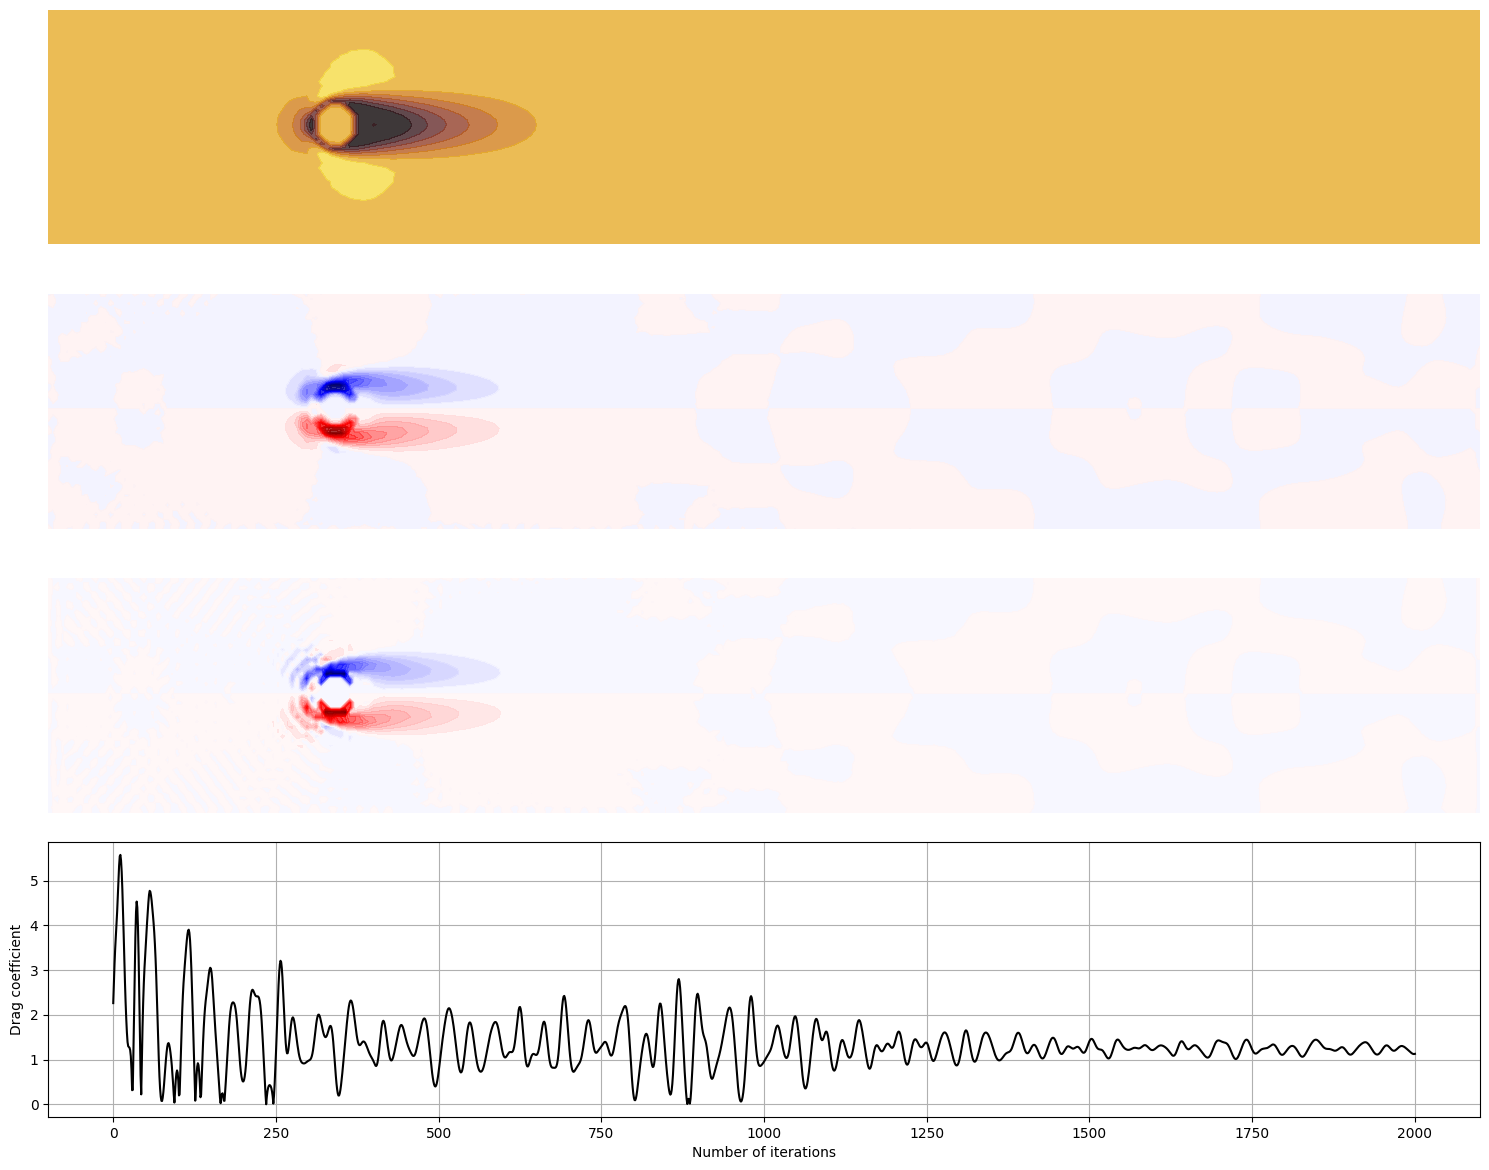

 50%|█████     | 2500/5000 [01:08<00:54, 45.77it/s]

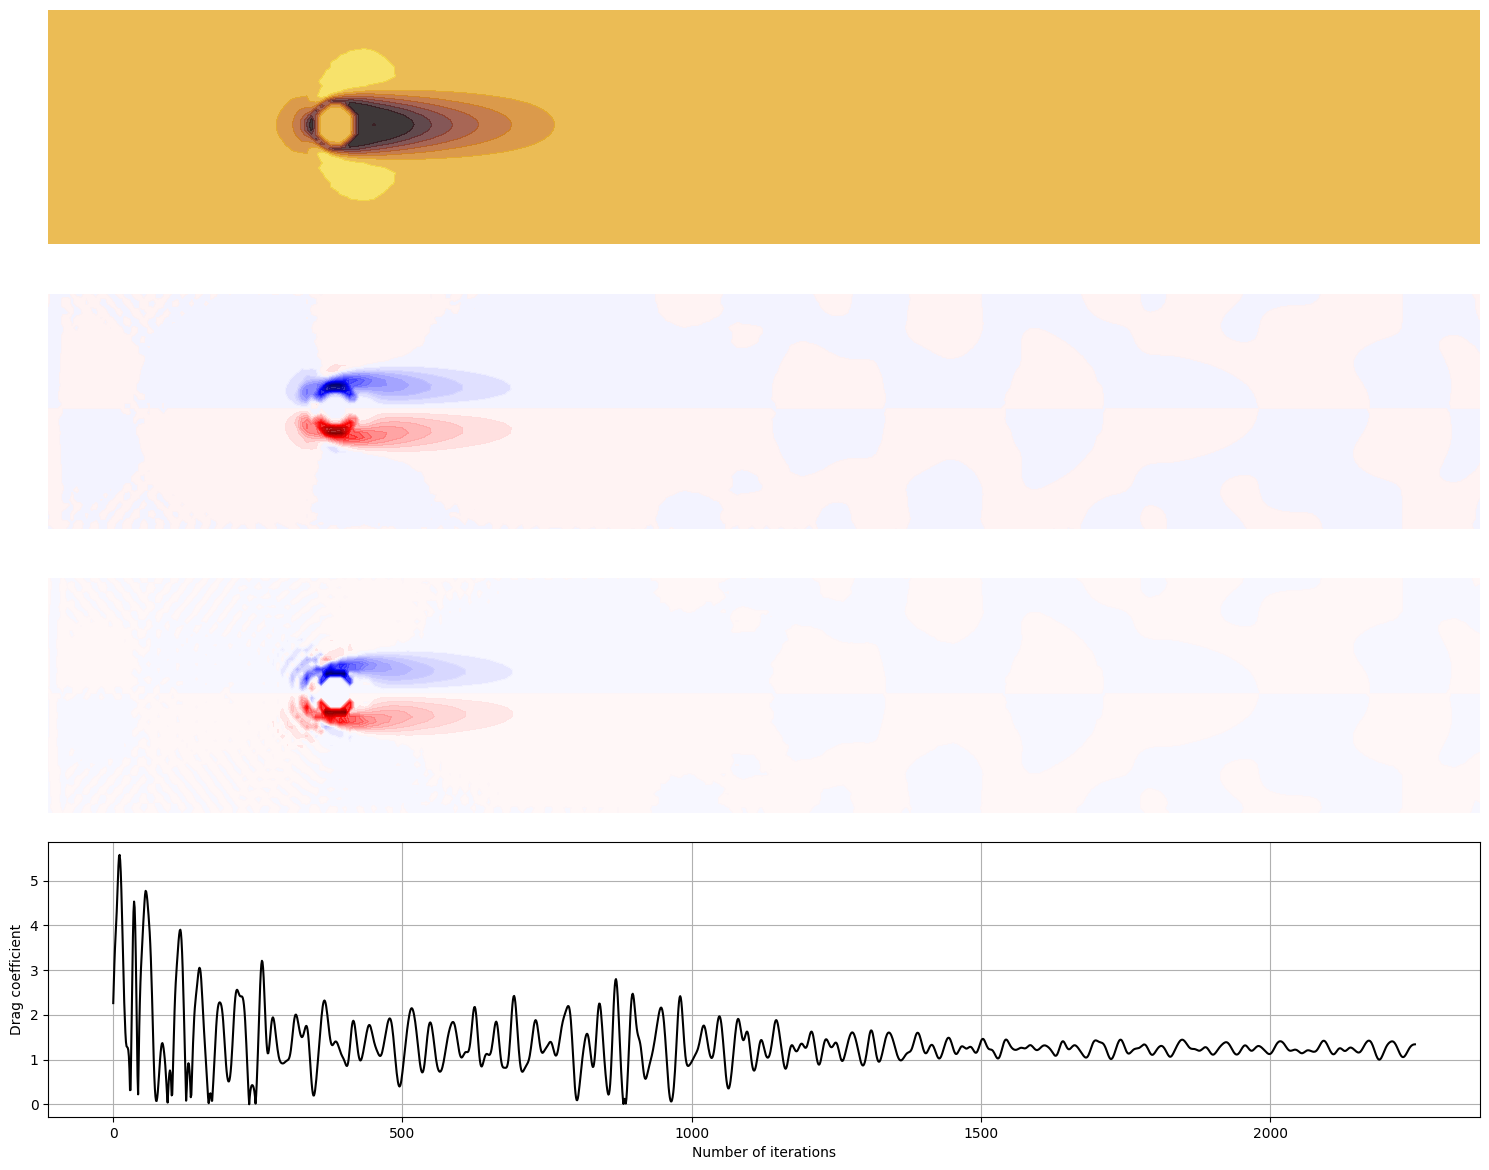

 54%|█████▍    | 2710/5000 [01:13<00:49, 46.12it/s]

In [ ]:
def run(discrete_velocities_prev, axis1 = 0, axis2 = 0):
    C_d = []
    for i in tqdm(range(NUMBER_OF_ITERATIONS)):
        discrete_velocities_next = update(discrete_velocities_prev)
        discrete_velocities_prev = discrete_velocities_next

        horizontal_force = get_force(discrete_velocities_next)[0]
        drag_coefficient = drag_coefficient = 2*abs(horizontal_force)/(1 * (jnp.pi * radius_L**2) * (HORIZONTAL_INFLOW_VELOCITY_L**2))
        C_d.append(drag_coefficient)

        if i % PLOT_EVERY_N_STEP == 0 and i > SKIP_FIRST_N - PLOT_EVERY_N_STEP:
            density = get_density(discrete_velocities_next)
            macroscopic_velocities = get_macroscopic_velocities(
                discrete_velocities_next,
                density)
            velocity_magnitude = jnp.linalg.norm(
                macroscopic_velocities,
                axis=-1,
                ord=2)

            strain_rate_tensor_FD = get_strain_rate_tensor_FD(macroscopic_velocities)
            strain_rate_FD = strain_rate_tensor_FD[..., axis1, axis2]

            strain_rate_tensor_LB = get_strain_rate_tensor_LB(discrete_velocities_next, macroscopic_velocities, density)
            strain_rate_LB = strain_rate_tensor_LB[..., axis1, axis2]

            fig, axs = plt.subplots(4, 1, figsize = (15, 12))
            axs[0].contourf(X[:, :, nz//2], Y[:, :,  nz//2],
                            velocity_magnitude[:, :,  nz//2],
                            alpha=0.8,
                            cmap=cmr.amber)
            axs[0].set_aspect('equal', adjustable='box')
            axs[0].axis('off')

            axs[1].contourf(X[:, :, nz//2], Y[:, :,  nz//2],
                            strain_rate_FD[..., nz//2],
                            levels = 50,
                            alpha = 0.8,
                            cmap = cm.seismic)
            axs[1].set_aspect('equal', adjustable='box')
            axs[1].axis('off')

            axs[2].contourf(X[:, :, nz//2], Y[:, :,  nz//2],
                            strain_rate_LB[..., nz//2],
                            levels = 50,
                            alpha = 0.8,
                            cmap = cm.seismic)

            axs[2].set_aspect('equal', adjustable='box')
            axs[2].axis('off')

            axs[3].plot(C_d[SKIP_FIRST_N:], 'k')
            axs[3].grid()
            axs[3].set_xlabel('Number of iterations')
            axs[3].set_ylabel('Drag coefficient')
            fig.tight_layout()
            plt.show()
    return discrete_velocities_next
discrete_velocities = run(discrete_velocities_prev,
                          axis1 = 0,
                          axis2 = 1)

## The results
The figures displayed in the results show velocity magnitude, finite difference solution for the stress tensor, the LB solution for the stress tensor and the drag coefficient over time.

When comparing the stress tensor as determined by FD and LB methods, the results seem quite similar, showing the same high and low areas. The FD solution seems to smooth the stress out more, however.

The drag coefficient starts of quite squigly. This periosicity will still remain, even at long simulations and a moving average sould be taken. At the start the drag coefficient varies between 0.0 and 2.5, but over time converges to a more steady appr. 1.25. This agrees only moderately well with the drag coefficient at $Re = 100$ on this chart:

![](https://upload.wikimedia.org/wikipedia/commons/thumb/4/4c/Drag_coefficient_of_a_sphere_as_a_function_of_Reynolds_number.png/800px-Drag_coefficient_of_a_sphere_as_a_function_of_Reynolds_number.png?20140624164653)

A slight deviation can be expected because we are not modeling a smooth sphere. In this application of the LBM, curved boundaries are step-wise!

With a higher resolution grid the simulation may take longer, but the drag coefficient will resemble that of a smooth sphere better. Try a sphere size of 8, and have the nx, ny and nz scale up correspondingly. It takes a lot longer, and with more the notebook will run out of memory, but the solution gets almost spot on!